In [1]:
import numpy as np

import load_mnist
import plot_utils

/Users/inesalmeida/work/02901_DTU/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load Data

In [2]:
X_train, y_train = load_mnist.load_train()
X_val, y_val, X_test, y_test = load_mnist.split_val_test(load_mnist.load_test())

Loaded 60000 patterns with 784 features.
Loaded 10000 patterns with 784 features.


### Visualize some examples

In [3]:
%matplotlib inline

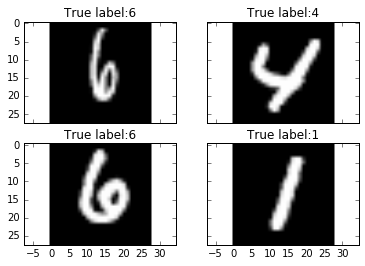

In [4]:
plot_utils.plot_a_few(X_train, y_train)

### Transform Data for ConvNet

In [5]:
from keras.utils import np_utils

Using Theano backend.


In [6]:
IMG_SIZE = 28
NUM_CLASSES = 10

def transform_Xy(X, y):
    X = X.reshape(X.shape[0], 1, IMG_SIZE, IMG_SIZE)
    X = X.astype('float32')
    X /= 255
    y = np_utils.to_categorical(y, NUM_CLASSES)
    return X, y

X_train, y_train = transform_Xy(X_train, y_train)
print X_train.shape, y_train.shape
X_val, y_val = transform_Xy(X_val, y_val)
X_test, y_test = transform_Xy(X_test, y_test)

(60000, 1, 28, 28) (60000, 10)


## Part 1: Basic Hyperparameter Estimation
We use a ConvNet. We want to estimate the most adequate dropout probabilities.

### Train a Basic ConvNet for Illustration

In [7]:
from conv_net import build_model

In [8]:
BATCH_SIZE = 10
NUM_EPOCHS = 12

# Build the model (ie the architecture)
model = build_model()

# Pick cost function, optimizer, metric
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# Train
model.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS,
          verbose=1, validation_data=(X_val, y_val))

Train on 60000 samples, validate on 2000 samples
Epoch 1/12
60000/60000 [==============================] - 225s - loss: 0.2512 - acc: 0.9232 - val_loss: 0.0803 - val_acc: 0.9740
Epoch 2/12
60000/60000 [==============================] - 229s - loss: 0.1152 - acc: 0.9670 - val_loss: 0.0620 - val_acc: 0.9800
Epoch 3/12
60000/60000 [==============================] - 230s - loss: 0.0998 - acc: 0.9709 - val_loss: 0.0562 - val_acc: 0.9815
Epoch 4/12
60000/60000 [==============================] - 231s - loss: 0.0954 - acc: 0.9727 - val_loss: 0.0504 - val_acc: 0.9830
Epoch 5/12
60000/60000 [==============================] - 231s - loss: 0.0952 - acc: 0.9735 - val_loss: 0.0457 - val_acc: 0.9845
Epoch 6/12
60000/60000 [==============================] - 232s - loss: 0.0958 - acc: 0.9740 - val_loss: 0.0469 - val_acc: 0.9840
Epoch 7/12
60000/60000 [==============================] - 236s - loss: 0.1004 - acc: 0.9730 - val_loss: 0.0504 - val_acc: 0.9835
Epoch 8/12
60000/60000 [========================

In [9]:
def score(model, X, y):
    s = model.evaluate(X, y, verbose=0)
    print 'Score:', s[0], 'Accuracy:', s[1]
    
print 'Train',
score(model, X_train, y_train)
print 'Validation',
score(model, X_val, y_val)
print 'Test',
score(model, X_test, y_test)

Train Score: 0.0530848299437 Accuracy: 0.986866666667
Validation Score: 0.0571416673598 Accuracy: 0.985
Test Score: 0.0627455564458 Accuracy: 0.985


### 1D Bayesian Optimization Problem
By default, we pick p_drop = 0.25 for the second convolution layer. This value appeared from pure experience. The question is, could we find an adequate value using Bayesian Optimization?

We begin by defining our black-box function: f(p) = test_score(network_with_p_drop=p)

In [10]:
import GPyOpt

In [11]:
def f(p):
    m = build_model(p_drop2=p)
    
    # Pick cost function, optimizer, metric
    m.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
    # Train
    m.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS,
          verbose=1, validation_data=(X_val, y_val))

    score = m.evaluate(X_test, y_test, verbose=0)
    
    # For progress tracking
    print 'x:', p, 'score:', score[0], 'test acc:', score[1]
    
    # Return the score on the test set
    return score[0]

In [12]:
# Define the problem bounds and budget
bounds = [{'name': 'p', 'type': 'continuous', 'domain': (0.1,0.9)}]

In [13]:
# Initialize the problem
np.random.seed(123)
myBopt = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                             initial_design_numdata=5,
                                             acquisition_type='EI',
                                             exact_feval = True)

Train on 60000 samples, validate on 2000 samples
Epoch 1/12
60000/60000 [==============================] - 187s - loss: 0.3822 - acc: 0.8823 - val_loss: 0.1118 - val_acc: 0.9650
Epoch 2/12
60000/60000 [==============================] - 188s - loss: 0.1757 - acc: 0.9477 - val_loss: 0.0811 - val_acc: 0.9765
Epoch 3/12
60000/60000 [==============================] - 188s - loss: 0.1456 - acc: 0.9566 - val_loss: 0.0699 - val_acc: 0.9810
Epoch 4/12
60000/60000 [==============================] - 188s - loss: 0.1285 - acc: 0.9627 - val_loss: 0.0659 - val_acc: 0.9805
Epoch 5/12
60000/60000 [==============================] - 188s - loss: 0.1221 - acc: 0.9640 - val_loss: 0.0599 - val_acc: 0.9820
Epoch 6/12
60000/60000 [==============================] - 188s - loss: 0.1133 - acc: 0.9667 - val_loss: 0.0576 - val_acc: 0.9815
Epoch 7/12
60000/60000 [==============================] - 188s - loss: 0.1112 - acc: 0.9668 - val_loss: 0.0597 - val_acc: 0.9790
Epoch 8/12
60000/60000 [========================

In [14]:
# Run the optimization
max_iter = 15       # evaluation budget
max_time = 300      # time budget (5mins)
eps      = 10e-6    # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps)  

Train on 60000 samples, validate on 2000 samples
Epoch 1/12
60000/60000 [==============================] - 193s - loss: 0.2639 - acc: 0.9203 - val_loss: 0.0825 - val_acc: 0.9735
Epoch 2/12
60000/60000 [==============================] - 193s - loss: 0.1261 - acc: 0.9625 - val_loss: 0.0621 - val_acc: 0.9810
Epoch 3/12
60000/60000 [==============================] - 194s - loss: 0.1029 - acc: 0.9702 - val_loss: 0.0552 - val_acc: 0.9785
Epoch 4/12
60000/60000 [==============================] - 193s - loss: 0.0924 - acc: 0.9731 - val_loss: 0.0586 - val_acc: 0.9810
Epoch 5/12
60000/60000 [==============================] - 193s - loss: 0.0880 - acc: 0.9748 - val_loss: 0.0512 - val_acc: 0.9825
Epoch 6/12
60000/60000 [==============================] - 193s - loss: 0.0830 - acc: 0.9759 - val_loss: 0.0481 - val_acc: 0.9835
Epoch 7/12
60000/60000 [==============================] - 193s - loss: 0.0800 - acc: 0.9760 - val_loss: 0.0484 - val_acc: 0.9830
Epoch 8/12
60000/60000 [========================

In [15]:
# Print the Optimum
print 'x_opt:', myBopt.x_opt
print 'f(x_opt):', myBopt.fx_opt

x_opt: [ 0.32891147]
f(x_opt): [ 0.03797767]


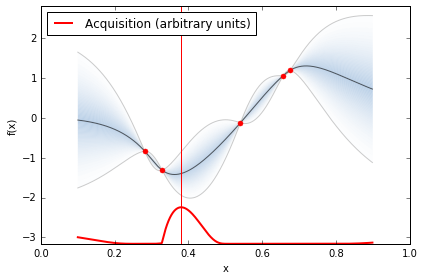

In [16]:
# Plot Expected Improvement
myBopt.plot_acquisition()

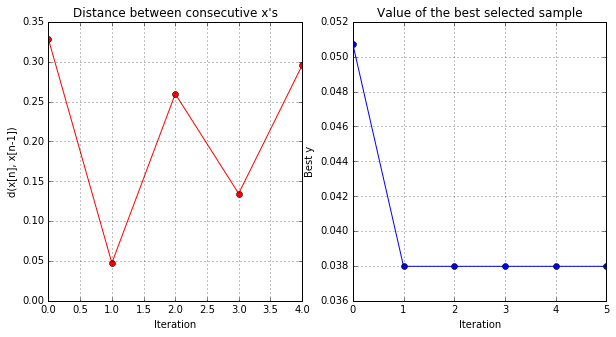

In [17]:
# Convergence
myBopt.plot_convergence()

### 2D Bayesian Optimization Problem
We now want to optimize two hyperparams: p_drop of the second convolutional layer, and p_drop of the (dense) hidden layer.

In [18]:
def f2(p):
    m = build_model(p_drop2=p[:, 0], p_drop3=p[:, 1])
    
    # Pick cost function, optimizer, metric
    m.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
    # Train
    m.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epoch=NUM_EPOCHS,
          verbose=1, validation_data=(X_val, y_val))

    score = m.evaluate(X_test, y_test, verbose=0)
    
    # For progress tracking
    print 'x:', p, 'score:', score[0], 'test acc:', score[1]
    
    # Return the score on the test set
    return score[0]

In [19]:
bounds2 =[{'name': 'p2', 'type': 'continuous', 'domain': (0.1, 0.9)},
         {'name': 'p3', 'type': 'continuous', 'domain': (0.1, 0.9)}]

In [25]:
# Initialize the problem
np.random.seed(123)
myBopt2D = GPyOpt.methods.BayesianOptimization(f2,
                                              domain=bounds2,
                                              model_type = 'GP',
                                              acquisition_type='LCB',  
                                              normalize_Y = True,
                                              acquisition_weight = 2)  

Train on 60000 samples, validate on 2000 samples
Epoch 1/12
60000/60000 [==============================] - 243s - loss: 0.3237 - acc: 0.9010 - val_loss: 0.1054 - val_acc: 0.9695
Epoch 2/12
60000/60000 [==============================] - 231s - loss: 0.1586 - acc: 0.9534 - val_loss: 0.0787 - val_acc: 0.9780
Epoch 3/12
60000/60000 [==============================] - 230s - loss: 0.1310 - acc: 0.9604 - val_loss: 0.0680 - val_acc: 0.9800
Epoch 4/12
60000/60000 [==============================] - 233s - loss: 0.1205 - acc: 0.9649 - val_loss: 0.0679 - val_acc: 0.9810
Epoch 5/12
60000/60000 [==============================] - 235s - loss: 0.1076 - acc: 0.9680 - val_loss: 0.0585 - val_acc: 0.9820
Epoch 6/12
60000/60000 [==============================] - 236s - loss: 0.1056 - acc: 0.9687 - val_loss: 0.0534 - val_acc: 0.9820
Epoch 7/12
60000/60000 [==============================] - 236s - loss: 0.1019 - acc: 0.9694 - val_loss: 0.0542 - val_acc: 0.9820
Epoch 8/12
60000/60000 [========================

In [26]:
# runs the optimization for the three methods
max_iter = 40  # maximum time 40 iterations
max_time = 500  # maximum time 60 seconds

myBopt2D.run_optimization(max_iter, max_time,verbosity=False)  

Train on 60000 samples, validate on 2000 samples
Epoch 1/12
60000/60000 [==============================] - 192s - loss: 0.1413 - acc: 0.9576 - val_loss: 0.0614 - val_acc: 0.9785
Epoch 2/12
60000/60000 [==============================] - 192s - loss: 0.0607 - acc: 0.9822 - val_loss: 0.0426 - val_acc: 0.9840
Epoch 3/12
60000/60000 [==============================] - 192s - loss: 0.0467 - acc: 0.9863 - val_loss: 0.0383 - val_acc: 0.9855
Epoch 4/12
60000/60000 [==============================] - 192s - loss: 0.0402 - acc: 0.9881 - val_loss: 0.0378 - val_acc: 0.9870
Epoch 5/12
60000/60000 [==============================] - 193s - loss: 0.0354 - acc: 0.9897 - val_loss: 0.0322 - val_acc: 0.9885
Epoch 6/12
60000/60000 [==============================] - 193s - loss: 0.0322 - acc: 0.9909 - val_loss: 0.0354 - val_acc: 0.9885
Epoch 7/12
60000/60000 [==============================] - 193s - loss: 0.0293 - acc: 0.9915 - val_loss: 0.0307 - val_acc: 0.9920
Epoch 8/12
60000/60000 [========================

In [27]:
# Print Optimum
print 'x_opt:', myBopt2D.x_opt
print 'f(x_opt):', myBopt2D.fx_opt

x_opt: [ 0.1  0.1]
f(x_opt): [ 0.03314655]


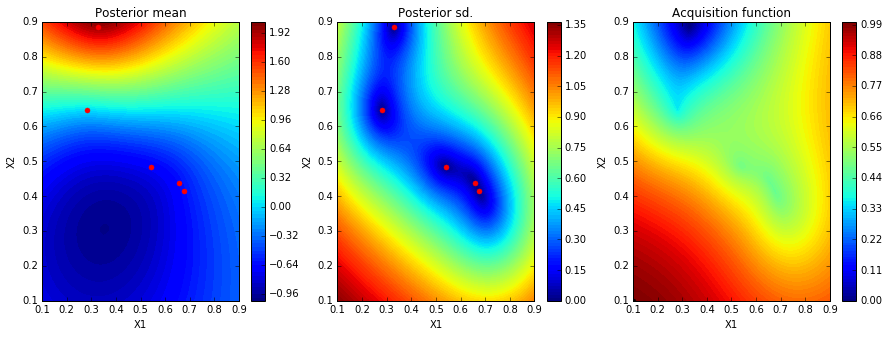

In [28]:
# Print LCB
myBopt2D.plot_acquisition()

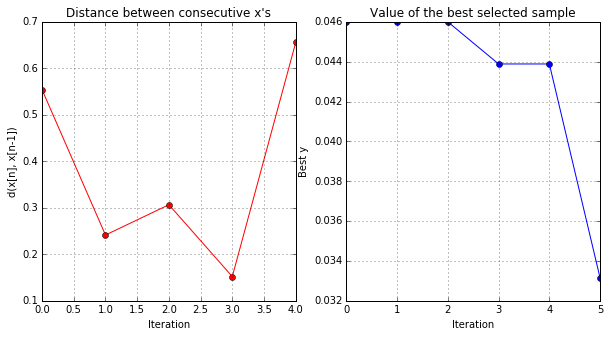

In [29]:
# Convergence
myBopt2D.plot_convergence()